In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
from manifoldembedder import *

In [5]:
file_dict = {'train':'/nobackup/users/sangeon/datasets/concat_temp.pt', 'val':'/nobackup/users/sangeon/datasets/concat_temp_val.pt','test':'/nobackup/users/sangeon/datasets/jetdataset_test.pt', 'predict':'/nobackup/users/sangeon/datasets/jetdataset_predict.pt'}

In [23]:
dataset = torch.load('/nobackup/users/sangeon/datasets/concat_temp.pt')

In [24]:
jetpair_train = DataLoader(dataset, batch_size=10000,shuffle=True,num_workers=4)

In [6]:
jetpair_dm = JetPairDataModule(file_dict,10000)

In [25]:
emd = np.array([])
for _,_,dist in jetpair_train:
    emd = np.concatenate([emd,dist.data.numpy()])

KeyboardInterrupt: 

In [26]:
emd

array([9.72924423e+01, 5.72407851e-03, 7.14656338e-02, ...,
       1.19080551e+02, 1.08121231e+02, 1.02129860e+02])

(array([6.800948e+06, 5.076500e+04, 3.489700e+04, 1.159120e+05,
        2.327439e+06, 3.895294e+06, 1.139450e+06, 2.023140e+05,
        2.136100e+04, 1.620000e+03]),
 array([-8.37981679e-06,  2.16105332e+01,  4.32210748e+01,  6.48316164e+01,
         8.64421581e+01,  1.08052700e+02,  1.29663241e+02,  1.51273783e+02,
         1.72884324e+02,  1.94494866e+02,  2.16105408e+02]),
 <BarContainer object of 10 artists>)

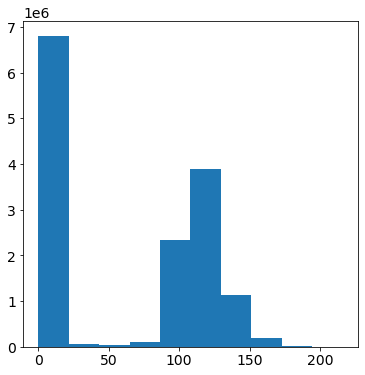

In [27]:
plt.hist(emd)

In [8]:
#d_model, nhead, num_encoder_layers, num_decoder_layers, embed_dim, max_seq_length, pos_dropout, trans_dropout, layer_widths

In [9]:
#lr, npart, embed_dim, hidden_size, num_rnn_layers, layer_widths

In [10]:
#model = ManifoldEmbedder("Transformer", 1e-2, 32, 16 ,8,8,2, 8, 0.7,0.7, [500,300,200,100,50,20,10])
#model = ManifoldEmbedder("MLP", 1e-2, 8, 2, [100,100,100,80,40,20,10])
model = ManifoldEmbedder('jets',"GRU", 1e-2, 8, 2, 40, 40, [500,200,50])


In [11]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder/7a151ea67d414eb2b8e01dda262250a9



In [12]:
comet_logger = CometLogger(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder",
)

CometLogger will be initialized in online mode


In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False)

In [14]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/home/sangeon/ToyJetGenerator/training/checkpoints",
    filename="GRU-mapeloss-normalizept-allpair-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)

In [15]:
trainer = Trainer(gpus=1,callbacks=[PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=comet_logger,auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting to init trainer!
Trainer is init now


In [16]:
trainer.fit(model, jetpair_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder/7a151ea67d414eb2b8e01dda262250a9
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (172.85 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder/c

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
a = trainer.predict(model, jetpair_dm)

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder/866fc48b14794bd5bec3861dc8bb98c8



Predicting: 58it [00:01, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder/866fc48b14794bd5bec3861dc8bb98c8
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages


In [18]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

Epoch 1:   2%|▏         | 58/3550 [00:50<50:19,  1.16it/s, loss=4.15e+03, v_num=98c8, train_loss=4.1e+3, val_loss=2.24e+3]

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

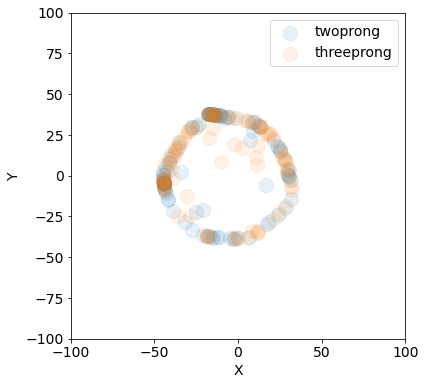

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedding[label==0][:100,0],embedding[label==0][:100,1],s=200,alpha=0.1,label='twoprong')
ax.scatter(embedding[label==1][:100,0],embedding[label==1][:100,1],s=200,alpha=0.1,label='threeprong')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-100,100])
ax.set_ylim([-100,100])
ax.legend()
fig.savefig(f'../figures/embedding.png')

(-100.0, 100.0)

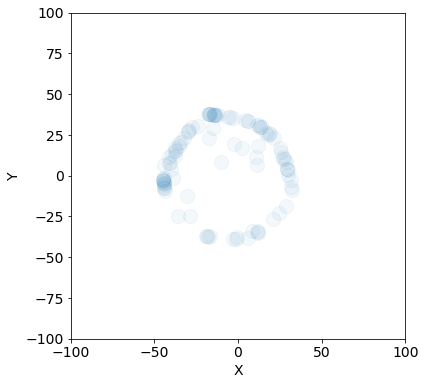

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.scatter(embedding[label==0][:1000,0],embedding[label==0][:1000,1],s=200,alpha=0.05)
ax.scatter(embedding[label==1][:100,0],embedding[label==1][:100,1],s=200,alpha=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
#fig.savefig(f'{path}/{name}.png')

In [42]:
embedding[label==0]

array([[34.16513062, -1.49830151],
       [34.1387825 , -1.53783011],
       [34.53158569, -0.93025315],
       ...,
       [34.1339798 , -1.54286742],
       [30.40222168,  5.07749081],
       [34.23294067, -1.4946003 ]])

In [43]:
embedding[label==1]

array([[34.15142822, -1.52005196],
       [34.01434708, -1.64321101],
       [34.10200119, -1.60349095],
       ...,
       [34.09588623, -1.59495401],
       [34.40365982, -1.46968496],
       [34.20943451, -1.48509216]])

In [41]:
label

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
experiment.end()

In [ ]:
import tensorboard

In [11]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6007 (pid 2019324), started 0:02:41 ago. (Use '!kill 2019324' to kill it.)